# Lead Scoring Case study
The X Education company is an Online Education Company that wants a model using which the Lead conversion rate can shoot up to 80% from current 30%.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('max_rows', 50);
pd.set_option('max_columns', None);

# Step 1 : Data Reading  

In [2]:
leads = pd.read_csv('./data/Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
leads.shape

(9240, 37)

In [4]:
leads.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [5]:
leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


# Step 2: Data Cleaning and Preparation
1. Drop unnecessary columns: This will include columns with unique values such as Prospect ID, Lead Number. Also the columns created by Sales team for internal data shall be removed. 
2. Check for high null percentage columns and drop them
3. Remove columns with high skewness
4. Remove rows with more than 5 null values
5. Impute the columns for null data
6. Treatment of Outliers
7. Check for Skewness in Numerical fields after imputing and handling outliers
8. Bucket Low percentage of categorical data into one category

### 1. Drop unnecessary columns 

In [6]:
unnecessary_columns = ['Prospect ID', 'Lead Number', 'Tags', 'Asymmetrique Activity Index', 'Lead Profile', 'Asymmetrique Profile Index',
                       'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
leads.drop(unnecessary_columns, axis = 1, inplace= True)
leads.shape

(9240, 29)

### 2. Check for high percentage of null data

In [7]:
leads.isnull().sum()

Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

### For many column values, the value `Select` implies that the corresponding data is not updated for the lead. So we will replace the `Select` value with NaN

In [8]:
leads.replace(to_replace="Select", value=np.NaN, inplace=True)

In [9]:
leads.isnull().sum()

Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

In [10]:
# Percentage of Null Values

round((leads.isnull().sum()/len(leads.index)) * 100, 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [11]:
# Remove columns with high percentage of null data
high_nullish_columns = ['How did you hear about X Education', 'Lead Quality'];
leads.drop(high_nullish_columns, axis = 1, inplace = True)
round((leads.isnull().sum()/len(leads)) * 100, 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [12]:
leads.shape

(9240, 27)

In [13]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 27 columns):
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   5860 non-null object
What is your current occupation                  6550 non-null object
What matters most to you in choosing a course    6531

### 3. Remove Highly skewed columns

In [14]:
datatypes = leads.dtypes
categorical_data = list(datatypes[datatypes == 'object'].index)
categorical_data

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Last Activity',
 'Country',
 'Specialization',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'City',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

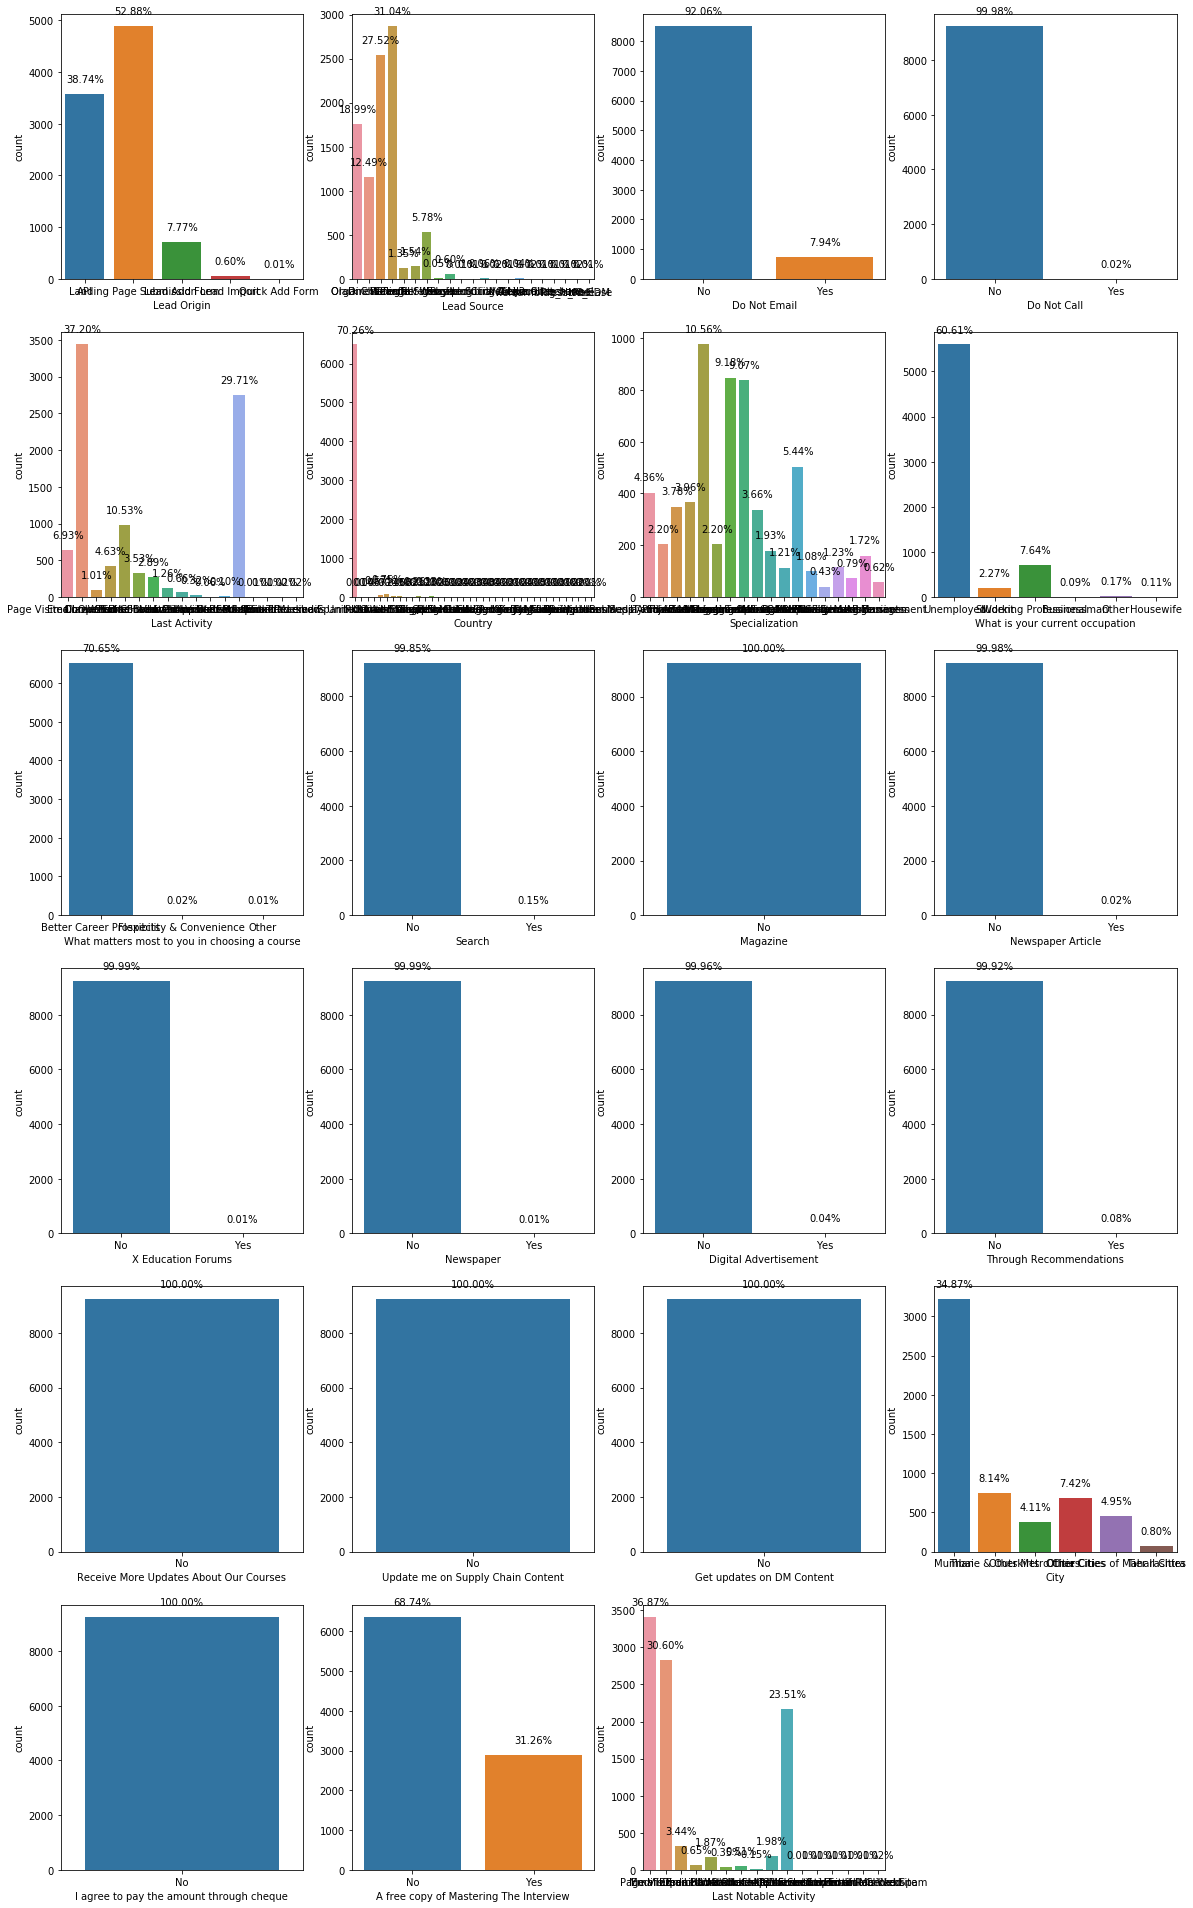

In [15]:
# barplots
plt.figure(figsize=(20,40))
for i in enumerate(categorical_data): 
    ax = plt.subplot(7,4, i[0]+1)
    sns.countplot(x=i[1], data=leads)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%\n'.format(100 * height/len(leads)),
                ha="center") 

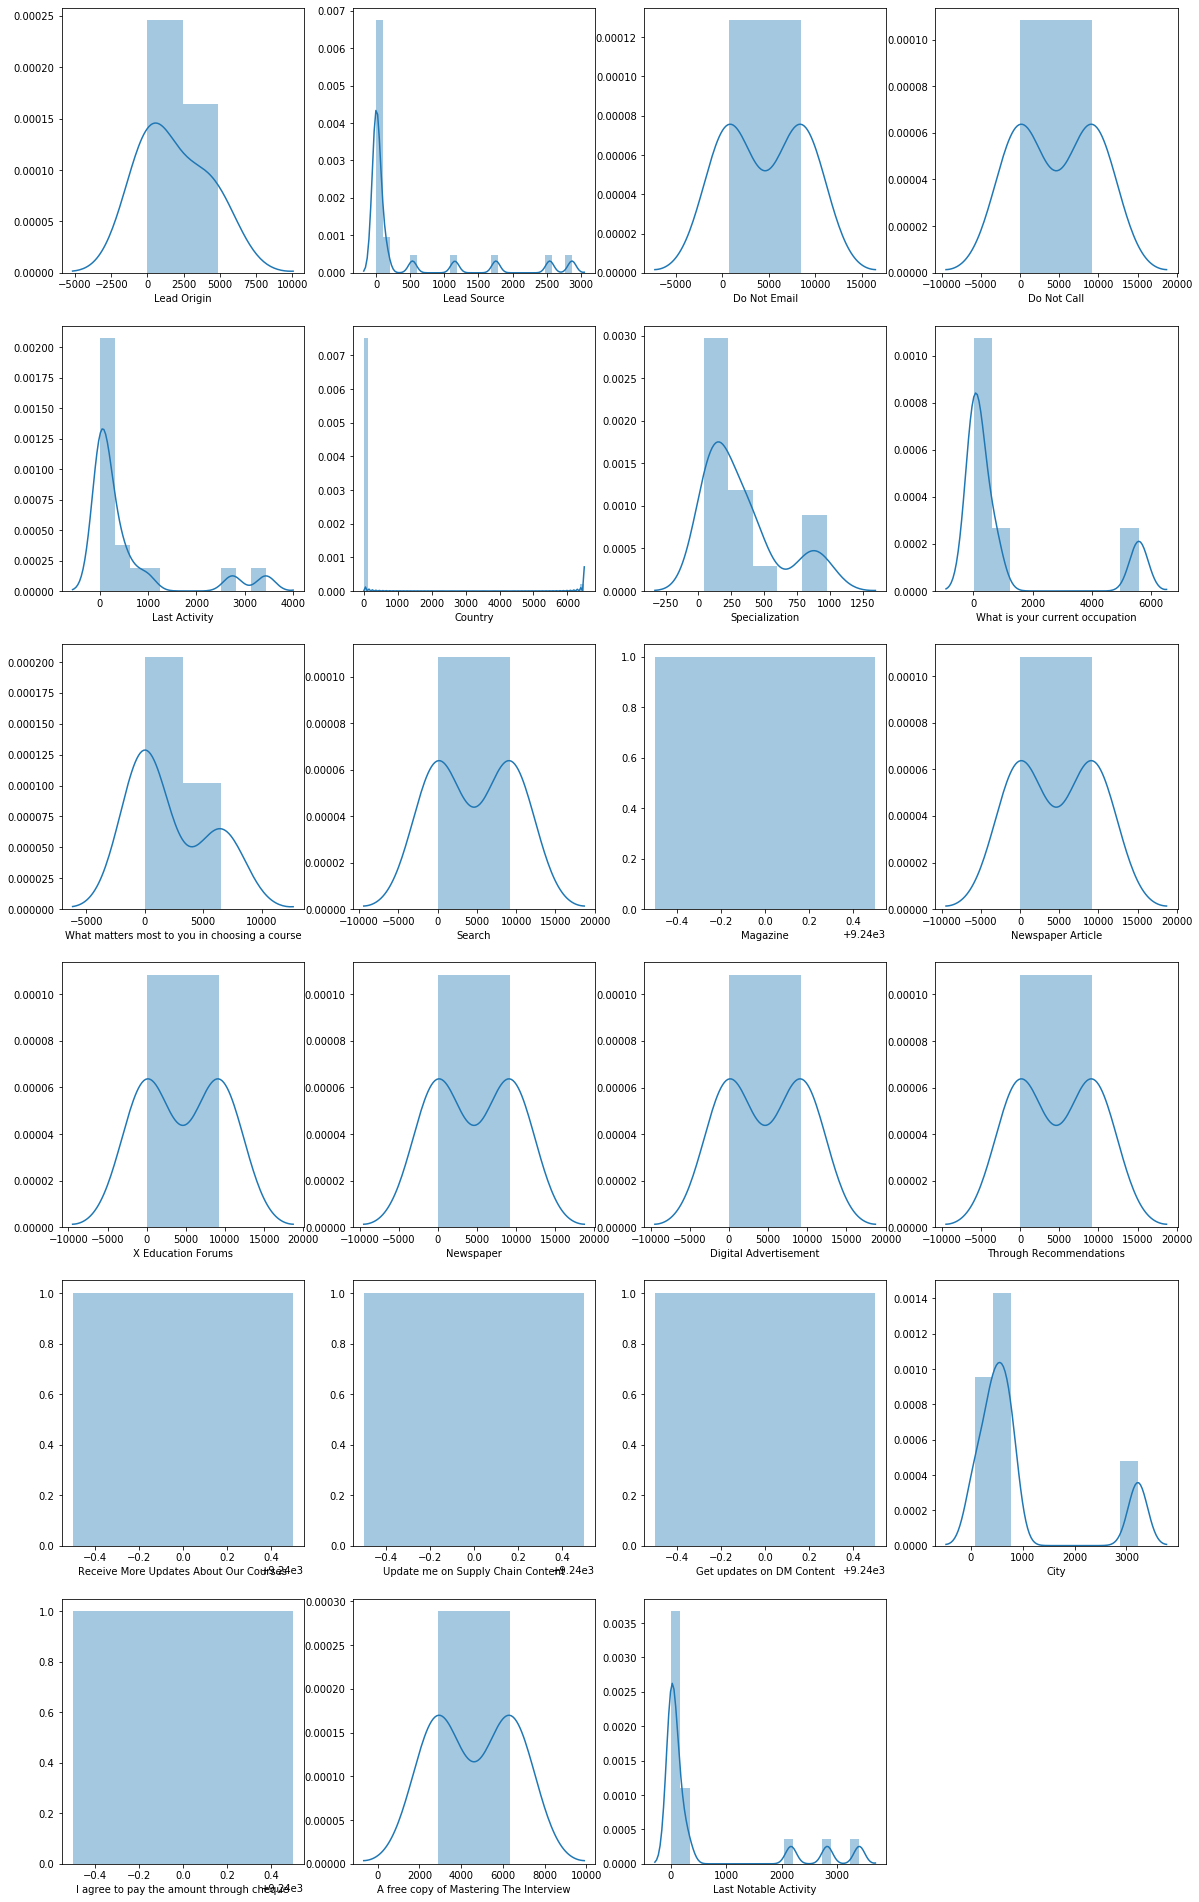

In [16]:
#checking distribution
plt.figure(figsize=(20,40))
for i in enumerate(categorical_data): 
    ax = plt.subplot(7,4, i[0]+1)
    sns.distplot(leads[i[1]].value_counts())

In [17]:
categorical_data

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Last Activity',
 'Country',
 'Specialization',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'City',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

In [18]:
# Highly skewed data
highly_skewed = ['Do Not Email', 'Do Not Call', 'Country','What is your current occupation' ,'What matters most to you in choosing a course',
                 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums',
                 'Newspaper', 'Digital Advertisement', 'Through Recommendations',
                 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content',
                 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'City','Last Notable Activity'
                ]
leads.drop(highly_skewed, axis=1, inplace=True)
leads.shape

(9240, 9)

In [19]:
leads.head()

,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,A free copy of Mastering The Interview
0,API,Olark Chat,0,0.0,0,0.0,Page Visited on Website,NaN,No
1,API,Organic Search,0,5.0,674,2.5,Email Opened,NaN,No
2,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Opened,Business Administration,Yes
3,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Unreachable,Media and Advertising,No
4,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,NaN,No


In [20]:
round((leads.isnull().sum()/len(leads)) * 100, 2)

Lead Origin                                0.00
Lead Source                                0.39
Converted                                  0.00
TotalVisits                                1.48
Total Time Spent on Website                0.00
Page Views Per Visit                       1.48
Last Activity                              1.11
Specialization                            36.58
A free copy of Mastering The Interview     0.00
dtype: float64

### 4. Remove the rows with more than 5 null values 

In [21]:
print(len(leads[leads.isnull().sum(axis=1) > 5].index))

0


#### As no such rows so no removal required

### 5. Impute the columns for null data
1. Categorical Data: Impute with Mode
2. Numerical Data: Check for outliers
    a. If Outliers are present, bin the outliers and then replace null with median
    b. If no outliers, replace null with mean

#### 5.1. Categorical Data : Impute with Mode

In [22]:
# List of categorical data with null values
categorical_nullish_data = ['Lead Source', 'Last Activity', 'Specialization']
for col in categorical_nullish_data:
    mode_value = leads[col].mode(dropna=True)[0]
    leads[col].fillna(mode_value, inplace=True)
round((leads.isnull().sum()/len(leads)) * 100, 2)

Lead Origin                               0.00
Lead Source                               0.00
Converted                                 0.00
TotalVisits                               1.48
Total Time Spent on Website               0.00
Page Views Per Visit                      1.48
Last Activity                             0.00
Specialization                            0.00
A free copy of Mastering The Interview    0.00
dtype: float64

#### Check for skewness in data after imputing with mode 

In [23]:
datatypes = leads.dtypes
categorical_data = list(datatypes[datatypes == 'object'].index)
categorical_data

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'A free copy of Mastering The Interview']

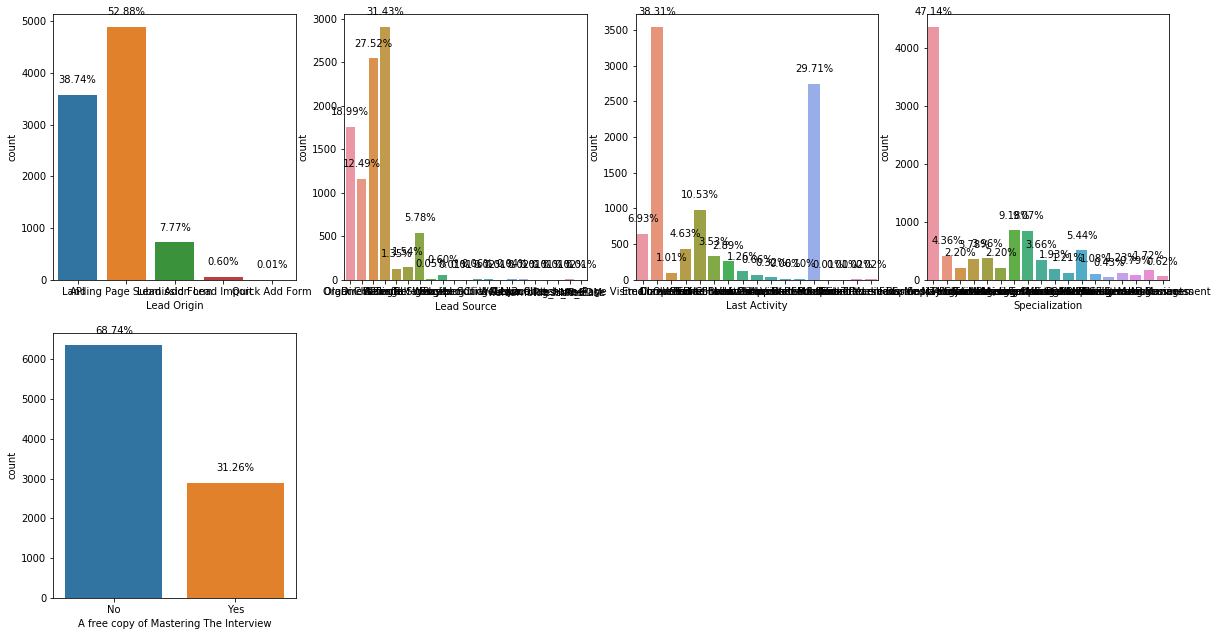

In [24]:
plt.figure(figsize=(20,40))
for i in enumerate(categorical_data): 
    ax = plt.subplot(7,4, i[0]+1)
    sns.countplot(x=i[1], data=leads)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%\n'.format(100 * height/len(leads)),
                ha="center") 

In [25]:
leads.shape

(9240, 9)

#### 5.2. Numerical Data : Check for outliers 

In [26]:
leads.describe(percentiles=[0.25, 0.50, 0.75, 0.95, 0.97, 0.98, 0.99])

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9103.000000,9240.000000,9103.000000
mean,0.385390,3.445238,487.698268,2.362820
std,0.486714,4.854853,548.021466,2.161418
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,12.000000,1.000000
50%,0.000000,3.000000,248.000000,2.000000
75%,1.000000,5.000000,936.000000,3.000000
95%,1.000000,10.000000,1562.000000,6.000000
97%,1.000000,11.000000,1660.000000,7.000000
98%,1.000000,13.000000,1734.000000,8.000000


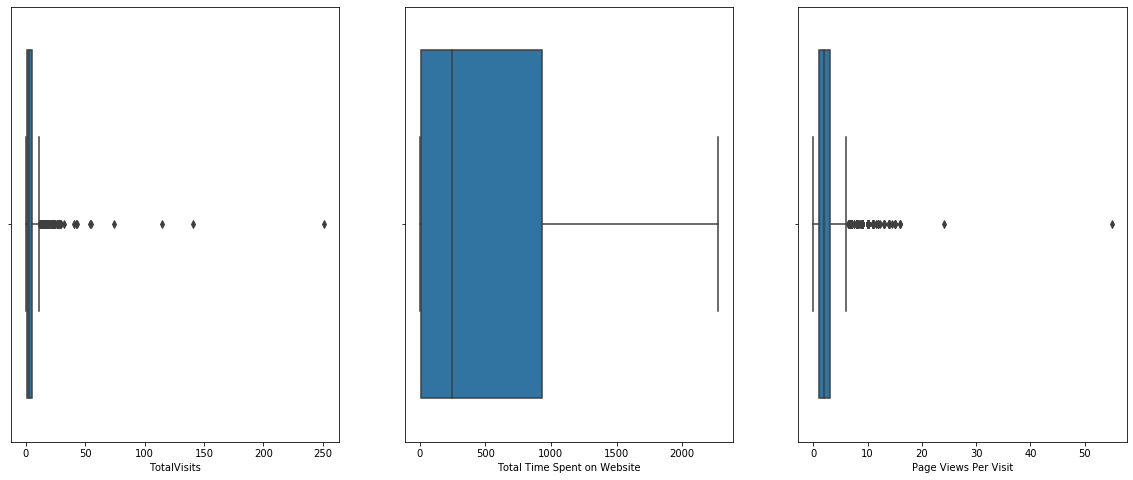

In [27]:
numeric_data = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
plt.figure(figsize = (20,8))
for i in enumerate(numeric_data): 
    ax = plt.subplot(1,3, i[0]+1)
    sns.boxplot(leads[i[1]])

#### 5.2.a. Columns with Outliers: `TotalVisits`, `Page Views Per Visit` **Impute null with Median**

In [28]:
leads['TotalVisits'].fillna(leads['TotalVisits'].median(), inplace = True)
leads['Page Views Per Visit'].fillna(leads['Page Views Per Visit'].median(), inplace = True)
round((leads.isnull().sum()/len(leads)) * 100, 2)

Lead Origin                               0.0
Lead Source                               0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Last Activity                             0.0
Specialization                            0.0
A free copy of Mastering The Interview    0.0
dtype: float64

#### 5.2.b. Columns with Outliers: `Total Time Spent on Website` **No Null Data so no treatment required**

### 6. Treatment of Outliers

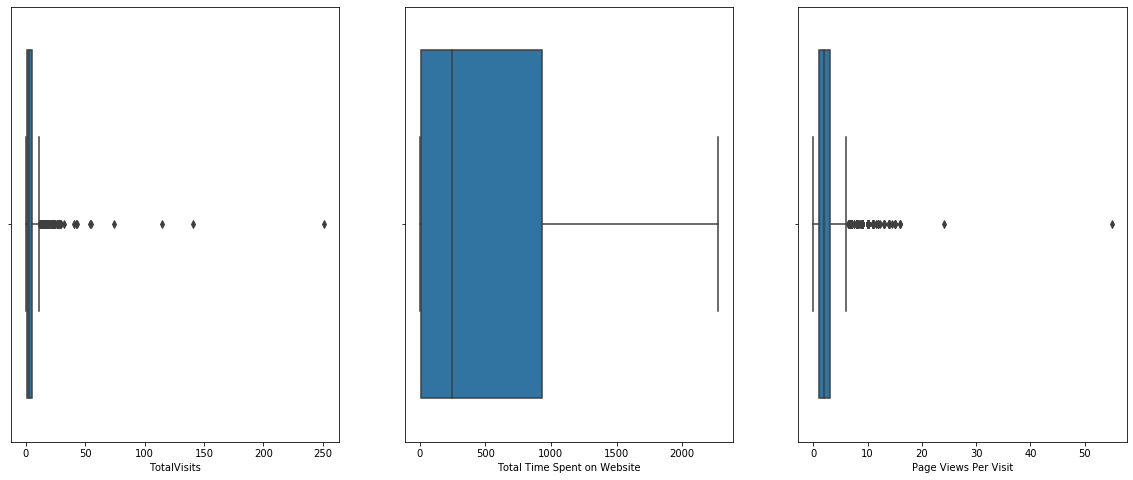

In [29]:
numeric_data = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
plt.figure(figsize = (20,8))
for i in enumerate(numeric_data): 
    ax = plt.subplot(1, 3, i[0]+1)
    sns.boxplot(leads[i[1]])

#### 6.1. Total Visits

In [30]:
Q4 = leads['TotalVisits'].quantile(0.99)
leads = leads[leads['TotalVisits'] <= Q4]
leads.shape
# Remove 0.1 percentile for TotalVisits, Page Views Per Visit

(9157, 9)

#### 6.2. Page Views Per Visit

In [31]:
Q4 = leads['Page Views Per Visit'].quantile(0.99)
leads = leads[leads['Page Views Per Visit'] <= Q4]
leads.shape

(9090, 9)

### 7. Check for Skewness in Numerical fields after imputing and handling outliers

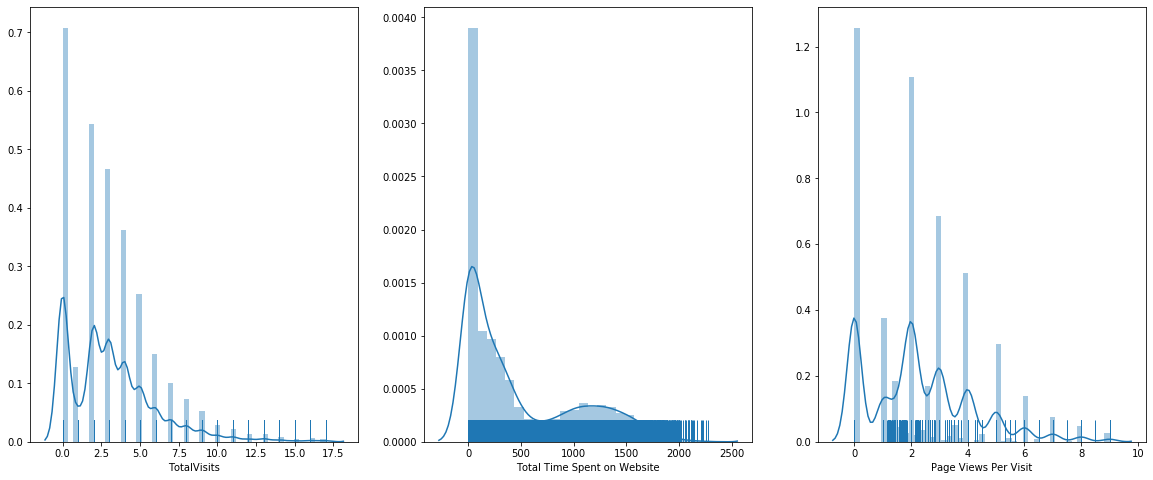

In [32]:
numeric_data = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
plt.figure(figsize=(20,8))
for i in enumerate(numeric_data): 
    ax = plt.subplot(1,3, i[0]+1)
    sns.distplot(leads[i[1]], rug=True)

In [33]:
leads.shape

(9090, 9)

### 8. Bucket Low percentage of categorical data into one category 

In [34]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 9 columns):
Lead Origin                               9090 non-null object
Lead Source                               9090 non-null object
Converted                                 9090 non-null int64
TotalVisits                               9090 non-null float64
Total Time Spent on Website               9090 non-null int64
Page Views Per Visit                      9090 non-null float64
Last Activity                             9090 non-null object
Specialization                            9090 non-null object
A free copy of Mastering The Interview    9090 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 710.2+ KB


In [35]:
round(leads['Lead Origin'].value_counts(normalize=True)*100, 2)

Landing Page Submission    52.46
API                        39.03
Lead Add Form               7.89
Lead Import                 0.61
Quick Add Form              0.01
Name: Lead Origin, dtype: float64

In [36]:
series = leads['Lead Origin'].value_counts()
mask = (series/series.sum() * 100).lt(1)
leads['Lead Origin'] = np.where(leads['Lead Origin'].isin(series[mask].index),'Others', leads['Lead Origin'])
round(leads['Lead Origin'].value_counts(normalize=True)*100, 2)

Landing Page Submission    52.46
API                        39.03
Lead Add Form               7.89
Others                      0.62
Name: Lead Origin, dtype: float64

In [37]:
round(leads['Lead Source'].value_counts(normalize=True)*100, 2)

Google               31.60
Direct Traffic       27.49
Olark Chat           19.28
Organic Search       12.01
Reference             5.86
Welingak Website      1.56
Referral Sites        1.29
Facebook              0.61
bing                  0.07
google                0.06
Click2call            0.04
Live Chat             0.02
Social Media          0.02
testone               0.01
welearnblog_Home      0.01
Press_Release         0.01
NC_EDM                0.01
Pay per Click Ads     0.01
WeLearn               0.01
youtubechannel        0.01
blog                  0.01
Name: Lead Source, dtype: float64

In [38]:
series = leads['Lead Source'].value_counts()
mask = (series/series.sum() * 100).lt(6)
leads['Lead Source'] = np.where(leads['Lead Source'].isin(series[mask].index),'Others', leads['Lead Source'])
round(leads['Lead Source'].value_counts(normalize=True)*100, 2)

Google            31.60
Direct Traffic    27.49
Olark Chat        19.28
Organic Search    12.01
Others             9.61
Name: Lead Source, dtype: float64

In [39]:
round(leads['Last Activity'].value_counts(normalize=True)*100, 2)

Email Opened                    38.43
SMS Sent                        29.78
Olark Chat Conversation         10.64
Page Visited on Website          6.53
Converted to Lead                4.71
Email Bounced                    3.56
Email Link Clicked               2.90
Form Submitted on Website        1.25
Unreachable                      1.00
Unsubscribed                     0.66
Had a Phone Conversation         0.32
Approached upfront               0.10
View in browser link Clicked     0.04
Email Marked Spam                0.02
Email Received                   0.02
Resubscribed to emails           0.01
Visited Booth in Tradeshow       0.01
Name: Last Activity, dtype: float64

In [40]:
series = leads['Last Activity'].value_counts()
mask = (series/series.sum() * 100).lt(4)
leads['Last Activity'] = np.where(leads['Last Activity'].isin(series[mask].index),'Others', leads['Last Activity'])
round(leads['Last Activity'].value_counts(normalize=True)*100, 2)

Email Opened               38.43
SMS Sent                   29.78
Olark Chat Conversation    10.64
Others                      9.91
Page Visited on Website     6.53
Converted to Lead           4.71
Name: Last Activity, dtype: float64

In [41]:
round(leads['A free copy of Mastering The Interview'].value_counts(normalize=True)*100, 2)

No     69.22
Yes    30.78
Name: A free copy of Mastering The Interview, dtype: float64

In [42]:
round(leads.Specialization.value_counts(normalize=True)*100, 2)

Finance Management                   47.51
Human Resource Management             9.13
Marketing Management                  9.12
Operations Management                 5.48
Business Administration               4.33
IT Projects Management                3.96
Supply Chain Management               3.75
Banking, Investment And Insurance     3.61
Media and Advertising                 2.18
Travel and Tourism                    2.09
International Business                1.90
Healthcare Management                 1.68
Hospitality Management                1.21
E-COMMERCE                            1.19
Retail Management                     1.05
Rural and Agribusiness                0.77
E-Business                            0.62
Services Excellence                   0.42
Name: Specialization, dtype: float64

In [43]:
series = leads.Specialization.value_counts()
mask = (series/series.sum() * 100).lt(5)
leads['Specialization'] = np.where(leads['Specialization'].isin(series[mask].index),'Others', leads['Specialization'])
round(leads.Specialization.value_counts(normalize=True)*100, 2)

Finance Management           47.51
Others                       28.76
Human Resource Management     9.13
Marketing Management          9.12
Operations Management         5.48
Name: Specialization, dtype: float64

In [44]:
leads.head()

,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,A free copy of Mastering The Interview
0,API,Olark Chat,0,0.0,0,0.0,Page Visited on Website,Finance Management,No
1,API,Organic Search,0,5.0,674,2.5,Email Opened,Finance Management,No
2,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Opened,Others,Yes
3,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Others,Others,No
4,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,Finance Management,No


### Check the percentage of Rows left after Data Cleaning

In [45]:
leads.shape

(9090, 9)

In [46]:
print('Percentage of rows remaining : {}'.format(round(100 * len(leads.index)/9240, 2)))

Percentage of rows remaining : 98.38


# Step 3. Univariate Analysis

### 1. Check the data for percentage of leads converted

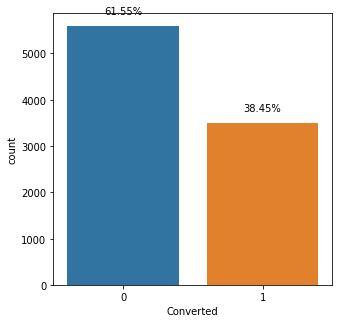

In [47]:
plt.figure(figsize = (5,5))
ax = sns.countplot(x="Converted", data=leads)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%\n'.format(100 * height/len(leads)),
            ha="center") 

### 2. Distribution of Categorical Data

In [48]:
leads.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 9 columns):
Lead Origin                               9090 non-null object
Lead Source                               9090 non-null object
Converted                                 9090 non-null int64
TotalVisits                               9090 non-null float64
Total Time Spent on Website               9090 non-null int64
Page Views Per Visit                      9090 non-null float64
Last Activity                             9090 non-null object
Specialization                            9090 non-null object
A free copy of Mastering The Interview    9090 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 1.0+ MB


In [49]:
datatypes = leads.dtypes
categorical_data = list(datatypes[datatypes == 'object'].index)
categorical_data

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'A free copy of Mastering The Interview']

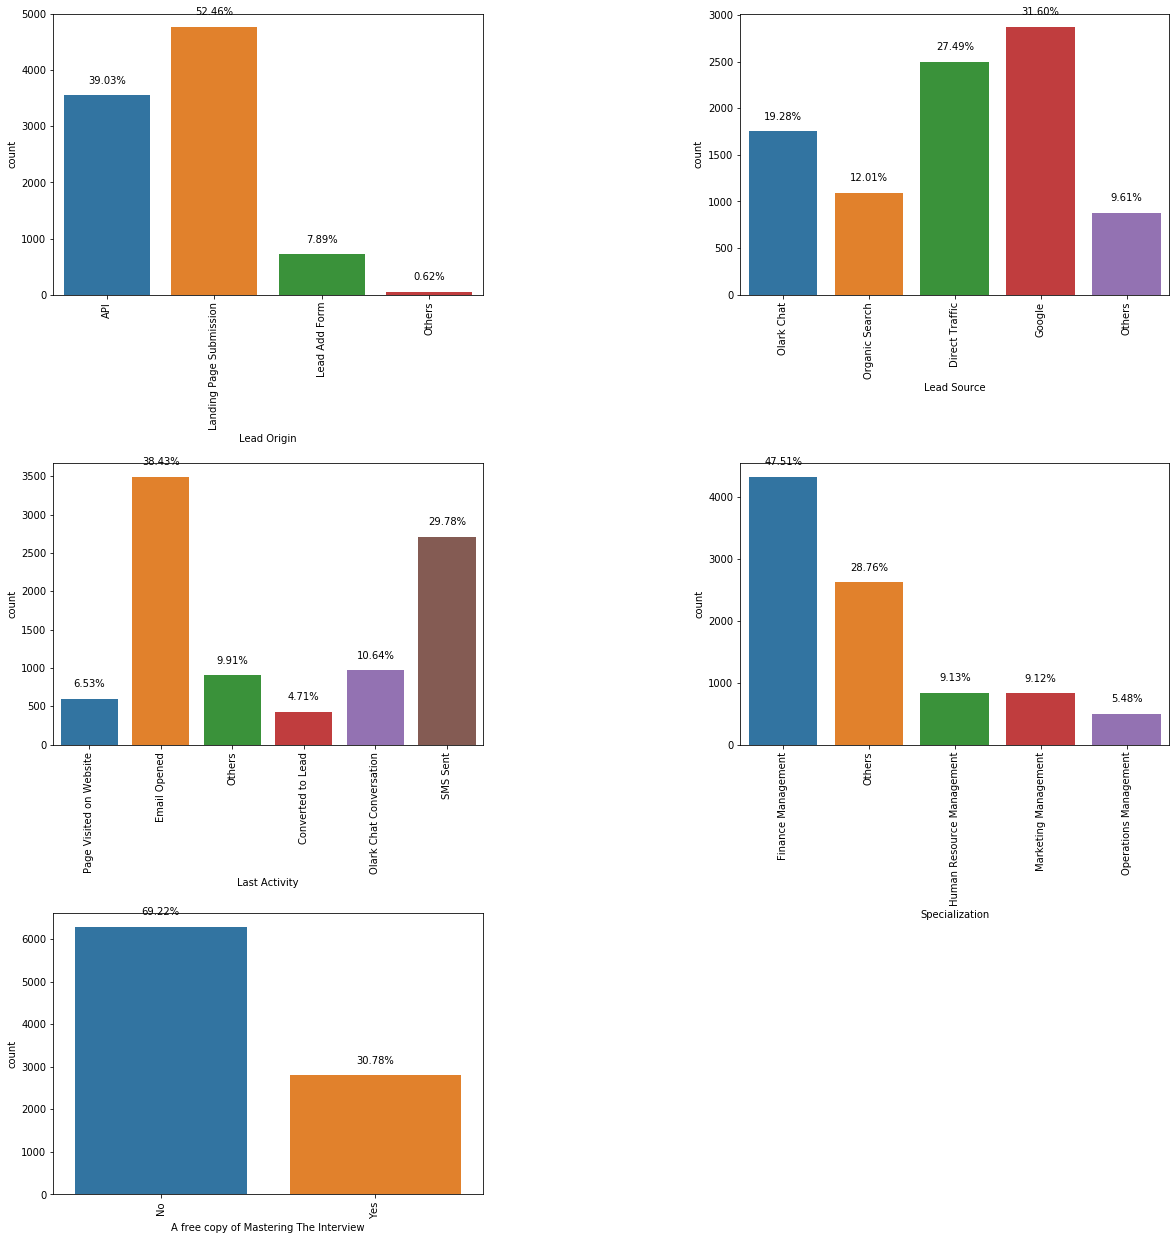

In [50]:
plt.figure(figsize=(20,30))
for i in enumerate(categorical_data): 
    ax = plt.subplot(4, 2, i[0]+1)
    plt.subplots_adjust(wspace = 0.6, hspace = 0.6)
    plt.xticks(rotation="vertical")
    sns.countplot(x=leads[i[1]], data=leads)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%\n'.format(100 * height/len(leads)),
                ha="center")

# Step 4. Bivariate Analysis 

### 1. Analysing Categorical Variables against `Converted` : 

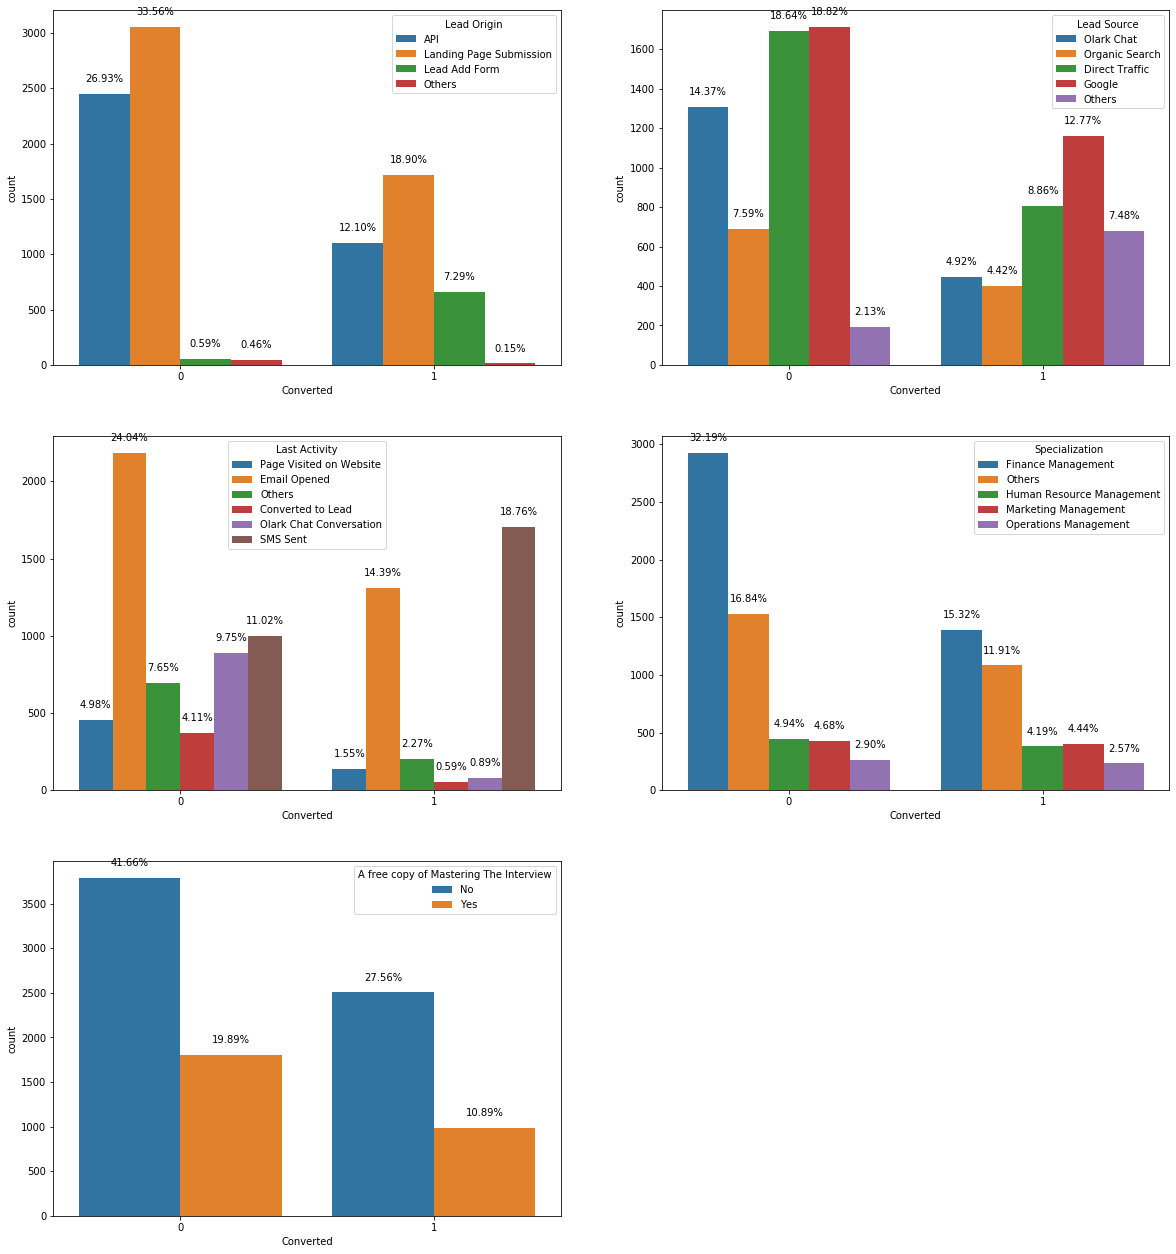

In [51]:
plt.figure(figsize=(20,30))
for i in enumerate(categorical_data): 
    ax = plt.subplot(4, 2, i[0]+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.2)
    sns.countplot(x="Converted",hue= i[1], data=leads)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%\n'.format(100 * height/len(leads)),
                ha="center")

### 2. Categorical Numerical Analysis

#### Converted vs Numerical Data

Numerical Variables: 'TotalVisits', 'Total Time Spent on Website' ,'Page Views Per Visit' 

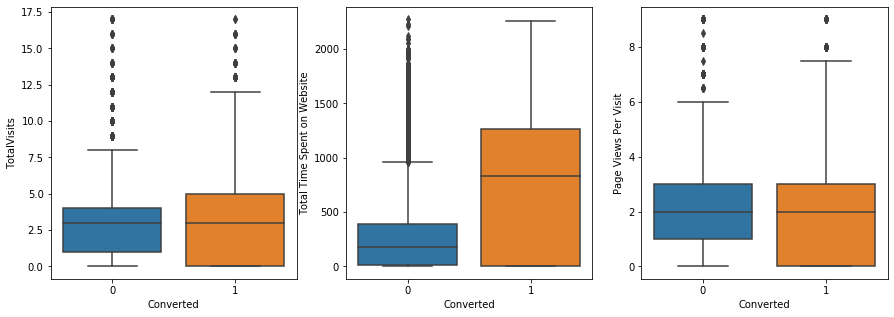

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(x = 'Converted', y = 'TotalVisits', data = leads)
plt.subplot(1,3,2)
sns.boxplot(x = 'Converted', y = 'Total Time Spent on Website', data = leads)
plt.subplot(1,3,3)
sns.boxplot(x = 'Converted', y = 'Page Views Per Visit', data = leads)
plt.show()

In [53]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 9 columns):
Lead Origin                               9090 non-null object
Lead Source                               9090 non-null object
Converted                                 9090 non-null int64
TotalVisits                               9090 non-null float64
Total Time Spent on Website               9090 non-null int64
Page Views Per Visit                      9090 non-null float64
Last Activity                             9090 non-null object
Specialization                            9090 non-null object
A free copy of Mastering The Interview    9090 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 1.0+ MB


### Numerical Data Analysis : Checking Correlation

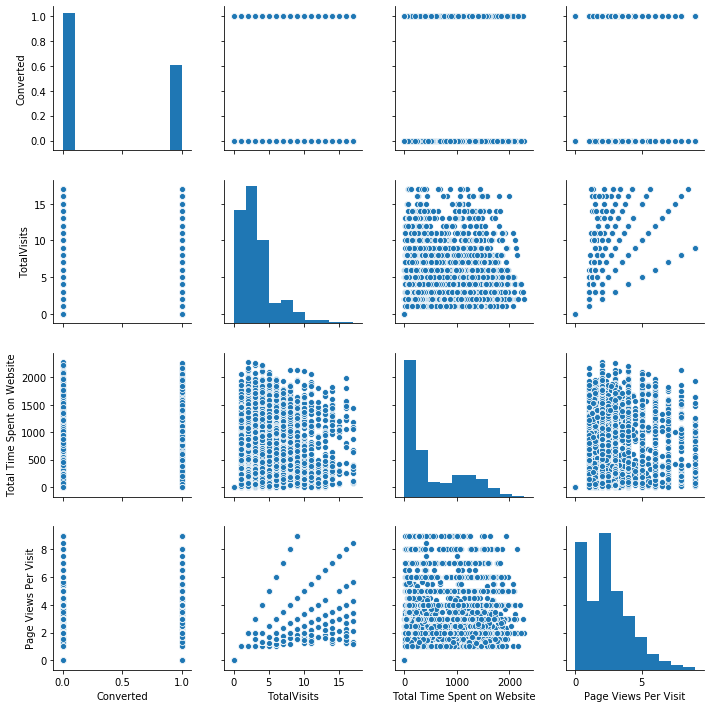

In [54]:
sns.pairplot(leads);

# Step 5.  Data Preparation 
1. Create Dummy variables for Categorical Data
2. Train Test split
3. Data Scaling

In [55]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090 entries, 0 to 9239
Data columns (total 9 columns):
Lead Origin                               9090 non-null object
Lead Source                               9090 non-null object
Converted                                 9090 non-null int64
TotalVisits                               9090 non-null float64
Total Time Spent on Website               9090 non-null int64
Page Views Per Visit                      9090 non-null float64
Last Activity                             9090 non-null object
Specialization                            9090 non-null object
A free copy of Mastering The Interview    9090 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 1.0+ MB


## Convert Categorical variables to Dummy Variables

In [56]:
origin = pd.get_dummies(leads['Lead Origin'])
origin.head()

,API,Landing Page Submission,Lead Add Form,Others
0,1,0,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [57]:
origin.drop('Others', axis = 1, inplace = True)
origin.head()

,API,Landing Page Submission,Lead Add Form
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0


In [58]:
# Concat origin with leads and drop Lead Origin column
leads = pd.concat([leads, origin], axis = 1)
leads.drop('Lead Origin', axis = 1, inplace=True)
leads.head()

,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,A free copy of Mastering The Interview,API,Landing Page Submission,Lead Add Form
0,Olark Chat,0,0.0,0,0.0,Page Visited on Website,Finance Management,No,1,0,0
1,Organic Search,0,5.0,674,2.5,Email Opened,Finance Management,No,1,0,0
2,Direct Traffic,1,2.0,1532,2.0,Email Opened,Others,Yes,0,1,0
3,Direct Traffic,0,1.0,305,1.0,Others,Others,No,0,1,0
4,Google,1,2.0,1428,1.0,Converted to Lead,Finance Management,No,0,1,0


In [59]:
source = pd.get_dummies(leads['Lead Source'])
source.head()

,Direct Traffic,Google,Olark Chat,Organic Search,Others
0,0,0,1,0,0
1,0,0,0,1,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [60]:
source.drop('Others', axis = 1, inplace = True)
source.head()

,Direct Traffic,Google,Olark Chat,Organic Search
0,0,0,1,0
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0


In [61]:
# Concat source with leads and drop Lead Source column
leads = pd.concat([leads, source], axis = 1)
leads.drop('Lead Source', axis = 1, inplace=True)
leads.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,A free copy of Mastering The Interview,API,Landing Page Submission,Lead Add Form,Direct Traffic,Google,Olark Chat,Organic Search
0,0,0.0,0,0.0,Page Visited on Website,Finance Management,No,1,0,0,0,0,1,0
1,0,5.0,674,2.5,Email Opened,Finance Management,No,1,0,0,0,0,0,1
2,1,2.0,1532,2.0,Email Opened,Others,Yes,0,1,0,1,0,0,0
3,0,1.0,305,1.0,Others,Others,No,0,1,0,1,0,0,0
4,1,2.0,1428,1.0,Converted to Lead,Finance Management,No,0,1,0,0,1,0,0


In [62]:
last_activity = pd.get_dummies(leads['Last Activity'])
last_activity.head()

,Converted to Lead,Email Opened,Olark Chat Conversation,Others,Page Visited on Website,SMS Sent
0,0,0,0,0,1,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,1,0,0,0,0,0


In [63]:
last_activity.drop('Others', axis = 1, inplace = True)
last_activity.head()

,Converted to Lead,Email Opened,Olark Chat Conversation,Page Visited on Website,SMS Sent
0,0,0,0,1,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,0,0,0
4,1,0,0,0,0


In [64]:
# Concat last_activity with leads and drop Last Activity column
leads = pd.concat([leads, last_activity], axis = 1)
leads.drop('Last Activity', axis = 1, inplace=True)
leads.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Specialization,A free copy of Mastering The Interview,API,Landing Page Submission,Lead Add Form,Direct Traffic,Google,Olark Chat,Organic Search,Converted to Lead,Email Opened,Olark Chat Conversation,Page Visited on Website,SMS Sent
0,0,0.0,0,0.0,Finance Management,No,1,0,0,0,0,1,0,0,0,0,1,0
1,0,5.0,674,2.5,Finance Management,No,1,0,0,0,0,0,1,0,1,0,0,0
2,1,2.0,1532,2.0,Others,Yes,0,1,0,1,0,0,0,0,1,0,0,0
3,0,1.0,305,1.0,Others,No,0,1,0,1,0,0,0,0,0,0,0,0
4,1,2.0,1428,1.0,Finance Management,No,0,1,0,0,1,0,0,1,0,0,0,0


In [65]:
specialization = pd.get_dummies(leads['Specialization'])
specialization.head()

,Finance Management,Human Resource Management,Marketing Management,Operations Management,Others
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,1,0,0,0,0


In [66]:
specialization.drop('Others', axis = 1, inplace = True)
specialization.head()

,Finance Management,Human Resource Management,Marketing Management,Operations Management
0,1,0,0,0
1,1,0,0,0
2,0,0,0,0
3,0,0,0,0
4,1,0,0,0


In [67]:
# Concat specialization with leads and drop Specialization column
leads = pd.concat([leads, specialization], axis = 1)
leads.drop('Specialization', axis = 1, inplace=True)
leads.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,API,Landing Page Submission,Lead Add Form,Direct Traffic,Google,Olark Chat,Organic Search,Converted to Lead,Email Opened,Olark Chat Conversation,Page Visited on Website,SMS Sent,Finance Management,Human Resource Management,Marketing Management,Operations Management
0,0,0.0,0,0.0,No,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,0,5.0,674,2.5,No,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,1,2.0,1532,2.0,Yes,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1.0,305,1.0,No,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2.0,1428,1.0,No,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0


#### `A free copy of Mastering The Interview` is a binary variable, so we will do Binary Mapping on this column

In [68]:
def binMap(x):
    return x.map({'Yes': 1, 'No': 0})

# Applying the binMap function to the column
leads['A free copy of Mastering The Interview'] = leads[['A free copy of Mastering The Interview']].apply(binMap)
leads.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,API,Landing Page Submission,Lead Add Form,Direct Traffic,Google,Olark Chat,Organic Search,Converted to Lead,Email Opened,Olark Chat Conversation,Page Visited on Website,SMS Sent,Finance Management,Human Resource Management,Marketing Management,Operations Management
0,0,0.0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,0,5.0,674,2.5,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,1,2.0,1532,2.0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1.0,305,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2.0,1428,1.0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [69]:
leads.shape

(9090, 21)

# Step 6.  Splitting the data into Train and Test Data 

In [70]:
X = leads.drop('Converted', axis = 1)
X.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,API,Landing Page Submission,Lead Add Form,Direct Traffic,Google,Olark Chat,Organic Search,Converted to Lead,Email Opened,Olark Chat Conversation,Page Visited on Website,SMS Sent,Finance Management,Human Resource Management,Marketing Management,Operations Management
0,0.0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,5.0,674,2.5,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,2.0,1532,2.0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,1.0,305,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2.0,1428,1.0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [71]:
y = leads.Converted
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [72]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size = 0.7, random_state = 100)

## Rescaling the Numeric Variables
It is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation.

In [73]:
# 1. Instantiate a StandardScaler Object
scaler = StandardScaler()

# 2. Create a list of numeric variables
numeric_data = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
X_train[numeric_data].head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
302,7.0,250,2.33
6087,0.0,0,0.00
1033,5.0,470,5.00
7656,6.0,352,6.00
3241,4.0,973,1.33


In [74]:
# 3. Fit and Transform the data
X_train[numeric_data] = scaler.fit_transform(X_train[numeric_data])
X_train.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,API,Landing Page Submission,Lead Add Form,Direct Traffic,Google,Olark Chat,Organic Search,Converted to Lead,Email Opened,Olark Chat Conversation,Page Visited on Website,SMS Sent,Finance Management,Human Resource Management,Marketing Management,Operations Management
302,1.336782,-0.428736,0.044021,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
6087,-1.094877,-0.887355,-1.206716,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1033,0.642022,-0.025151,1.477269,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
7656,0.989402,-0.241619,2.014065,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0
3241,0.294642,0.897591,-0.492776,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [75]:
X_train[numeric_data].describe()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,6.363000e+03,6.363000e+03,6.363000e+03
mean,-4.933627e-16,-1.354671e-16,2.880333e-16
std,1.000079e+00,1.000079e+00,1.000079e+00
min,-1.094877e+00,-8.873549e-01,-1.206716e+00
25%,-7.474975e-01,-8.671756e-01,-6.699187e-01
50%,-5.273755e-02,-4.360736e-01,-1.331219e-01
75%,6.420224e-01,8.168741e-01,4.036749e-01
max,4.810582e+00,3.280576e+00,3.624456e+00


### Checking the Probability Score

In [76]:
probability = round((sum(leads['Converted'])/len(leads['Converted'].index))* 100,2)
print(probability)

38.45


#### Currently the probability of the leads will be hot leads is **38.45%**

# Step 7. Modelling 

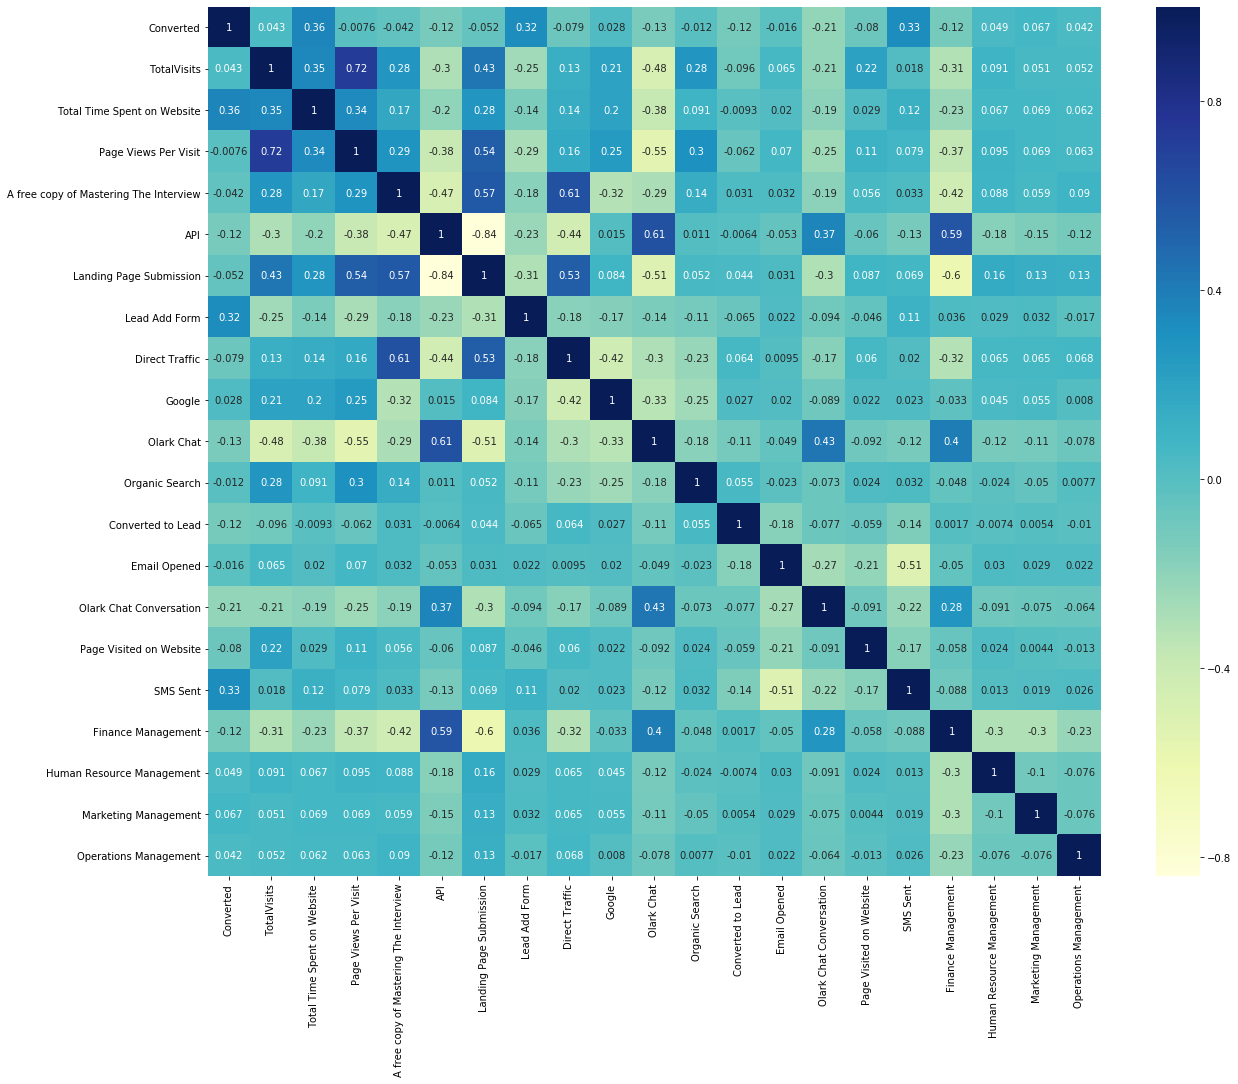

In [77]:
plt.figure(figsize = (20, 16))
ax = sns.heatmap(leads.corr(), annot= True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Printing top correalted columns

In [78]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=100):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print(get_top_abs_correlations(leads, 20))

API                                     Landing Page Submission    0.840582
TotalVisits                             Page Views Per Visit       0.721109
API                                     Olark Chat                 0.609761
A free copy of Mastering The Interview  Direct Traffic             0.609494
Landing Page Submission                 Finance Management         0.600782
API                                     Finance Management         0.587612
A free copy of Mastering The Interview  Landing Page Submission    0.568421
Page Views Per Visit                    Olark Chat                 0.550042
                                        Landing Page Submission    0.536032
Landing Page Submission                 Direct Traffic             0.534312
Email Opened                            SMS Sent                   0.514462
Landing Page Submission                 Olark Chat                 0.513515
TotalVisits                             Olark Chat                 0.476355
A free copy 

#### Dropping the highly correlated (>0.40) dummy variables

In [79]:
# Drop highly correlated dummy variables
highly_correlated = ['Landing Page Submission','Olark Chat Conversation','Olark Chat', 'Page Views Per Visit', 'Finance Management' ,'Direct Traffic', 'Email Opened', 'Google','A free copy of Mastering The Interview']

X_train.drop(highly_correlated, inplace=True, axis=1)
X_test.drop(highly_correlated, inplace=True, axis=1)

#### Check for correlation after dropping the highly correlated column

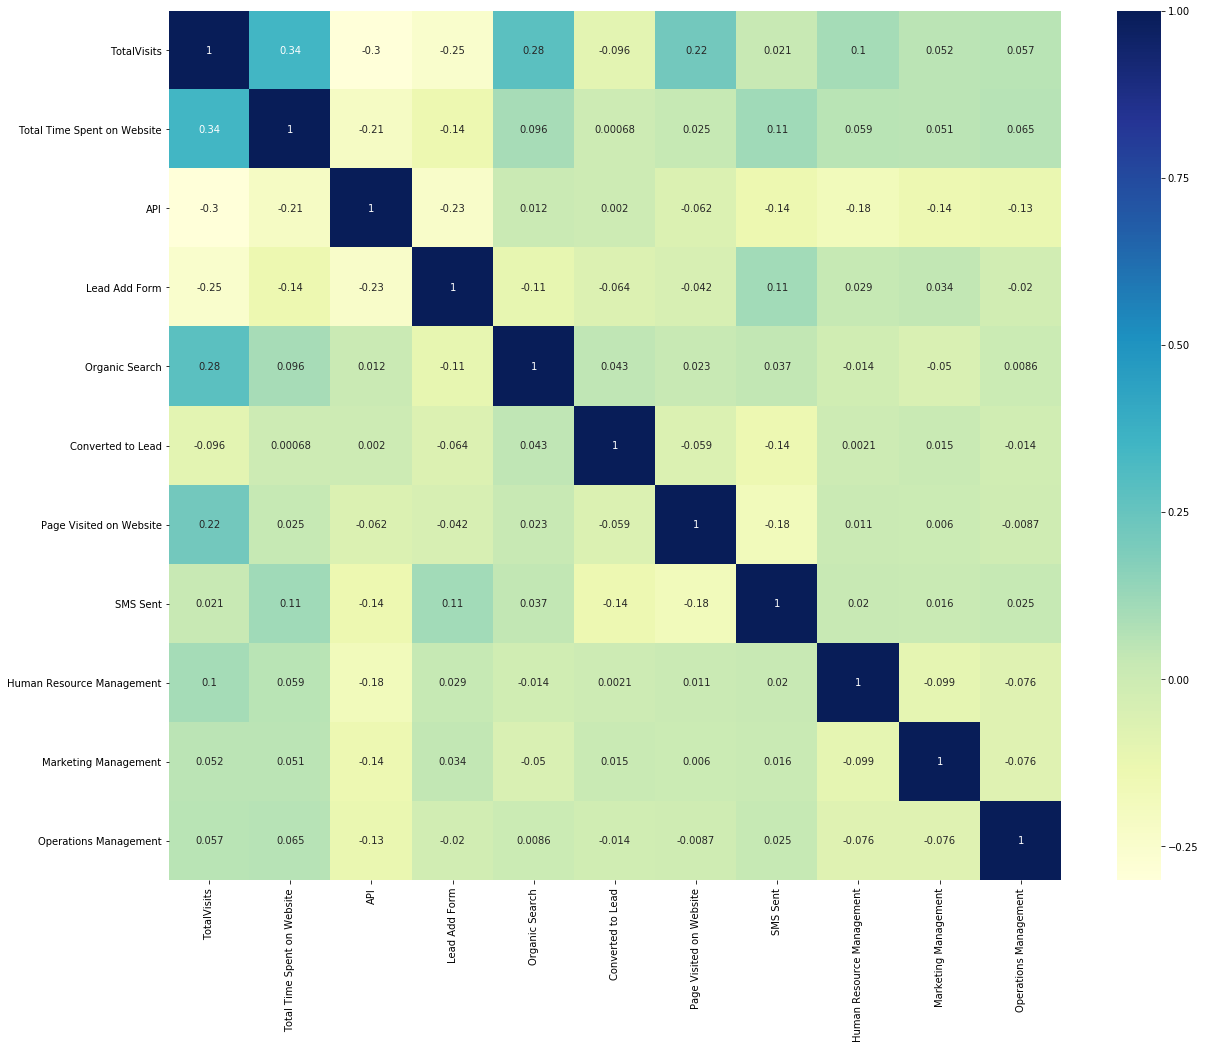

In [80]:
plt.figure(figsize = (20, 16))
ax = sns.heatmap(X_train.corr(), annot= True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [81]:
X_train.shape

(6363, 11)

## Building the model

I will be using the **GLM function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### Feature Selection through RFE

In [82]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [83]:
# Running RFE with the output number of the variable equal to 8
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 8)
rfe = rfe.fit(X_train, y_train)

In [84]:
rfe.support_

array([False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True])

In [85]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 4),
 ('Total Time Spent on Website', True, 1),
 ('API', True, 1),
 ('Lead Add Form', True, 1),
 ('Organic Search', False, 3),
 ('Converted to Lead', True, 1),
 ('Page Visited on Website', True, 1),
 ('SMS Sent', True, 1),
 ('Human Resource Management', False, 2),
 ('Marketing Management', True, 1),
 ('Operations Management', True, 1)]

In [86]:
col = X_train.columns[rfe.support_]
col

Index(['Total Time Spent on Website', 'API', 'Lead Add Form',
       'Converted to Lead', 'Page Visited on Website', 'SMS Sent',
       'Marketing Management', 'Operations Management'],
      dtype='object')

In [87]:
y=X_train.columns[~rfe.support_]
y

Index(['TotalVisits', 'Organic Search', 'Human Resource Management'], dtype='object')

### Assessing the model with StatsModels

In [88]:
# importing statsmodels
import statsmodels.api as sm 

In [89]:
# Creating X_test dataframe with RFE selected variables
X_train_model_1 = X_train[col]

In [90]:
# Adding a constant variable 
X_train_model_1= sm.add_constant(X_train_model_1)

In [91]:
# Logistic regression model
logm1 = sm.GLM(y_train, X_train_model_1, family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6363
Model:                            GLM   Df Residuals:                     6354
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3009.0
Date:                Mon, 01 Jun 2020   Deviance:                       6018.1
Time:                        21:58:58   Pearson chi2:                 6.54e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.4575      0.059    -24.647      0.000      -1.573      -1.342
Total Time Spent on Website     1.0201      0.034     29.608      0.000       0.953       1.088
API                             0.4476      0.072      6.257      0.000       0.307       0.588
Lead Add Form                   4.0795      0.185     22.076      0.000       3.717       4.442
Converted to Lead              -1.0033      0.194     -5.180      0.000      -1.383      -0.624
Page Visited on Website        -0.3620      0.138     -2.627      0.009      -0.632      -0.092
SMS Sent                        1.3736      0.070     19.524      0.000       1.236       1.511
Marketing Management            0.4415      0.110      4.028      0.000       0.227       0.656
Operations Management           0.4317      0.135      3.196      0.001       0.167       0.696
===============================================================================================
"""

### Checking VIF

In [92]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [93]:
# dropping constant
X_train_model_1_new=X_train_model_1.drop('const',1)

In [94]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_model_1_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_model_1_new.values, i) for i in range(X_train_model_1_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,SMS Sent,1.22
1,API,1.17
2,Lead Add Form,1.11
0,Total Time Spent on Website,1.09
6,Marketing Management,1.06
3,Converted to Lead,1.03
4,Page Visited on Website,1.03
7,Operations Management,1.03


In [95]:
y_train_pred = res.predict(X_train_model_1).values.reshape(-1)
y_train_pred

array([0.19042482, 0.12840863, 0.26201082, ..., 0.42453492, 0.48618163,
       0.09057895])

In [96]:
y_train_pred_final = pd.DataFrame({'HotLead':y_train.values, 'HotLead_Prob':y_train_pred})
y_train_pred_final['StudentID'] = y_train.index
y_train_pred_final.head(20)

,HotLead,HotLead_Prob,StudentID
0,0,0.190425,302
1,0,0.128409,6087
2,0,0.262011,1033
3,0,0.418143,7656
4,1,0.696723,3241
5,0,0.134769,5738
6,0,0.128409,7366
7,0,0.108301,3680
8,1,0.679047,4170
9,0,0.124851,43


### Plotting the ROC Curve

In [97]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [98]:
from sklearn import metrics

In [99]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.HotLead, y_train_pred_final.HotLead_Prob, drop_intermediate = False )

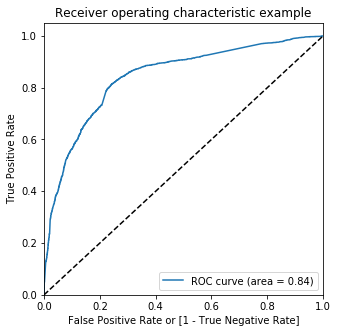

In [100]:
draw_roc(y_train_pred_final.HotLead, y_train_pred_final.HotLead_Prob)

### Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [101]:
# creating columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.HotLead_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,HotLead,HotLead_Prob,StudentID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.190425,302,1,1,0,0,0,0,0,0,0,0
1,0,0.128409,6087,1,1,0,0,0,0,0,0,0,0
2,0,0.262011,1033,1,1,1,0,0,0,0,0,0,0
3,0,0.418143,7656,1,1,1,1,1,0,0,0,0,0
4,1,0.696723,3241,1,1,1,1,1,1,1,0,0,0


In [102]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.HotLead, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.381581  1.000000  0.000000
0.1   0.1  0.456860  0.983114  0.132147
0.2   0.2  0.726230  0.886326  0.627446
0.3   0.3  0.769606  0.839374  0.726557
0.4   0.4  0.775263  0.704283  0.819060
0.5   0.5  0.773849  0.605025  0.878018
0.6   0.6  0.769291  0.525124  0.919949
0.7   0.7  0.748861  0.434514  0.942821
0.8   0.8  0.727487  0.336079  0.968996
0.9   0.9  0.672796  0.161038  0.988564


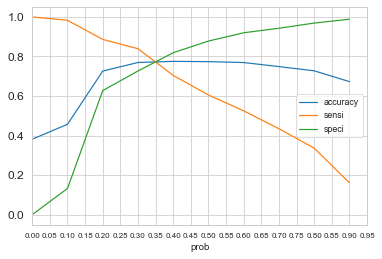

In [103]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
sns.set_style('whitegrid')
sns.set_context('paper')
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xticks(np.arange(0, 1, step = 0.05), size=8)
plt.yticks(size=12)
plt.show()

#### From the curve above, 0.35 (approximately) is the optimum point to take it as a cutoff probability.

In [104]:
y_train_pred_final['final_predicted'] = y_train_pred_final.HotLead_Prob.map( lambda x: 1 if x > 0.35 else 0)

y_train_pred_final.head()

,HotLead,HotLead_Prob,StudentID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.190425,302,1,1,0,0,0,0,0,0,0,0,0
1,0,0.128409,6087,1,1,0,0,0,0,0,0,0,0,0
2,0,0.262011,1033,1,1,1,0,0,0,0,0,0,0,0
3,0,0.418143,7656,1,1,1,1,1,0,0,0,0,0,1
4,1,0.696723,3241,1,1,1,1,1,1,1,0,0,0,1


In [105]:
X_train.columns

Index(['TotalVisits', 'Total Time Spent on Website', 'API', 'Lead Add Form',
       'Organic Search', 'Converted to Lead', 'Page Visited on Website',
       'SMS Sent', 'Human Resource Management', 'Marketing Management',
       'Operations Management'],
      dtype='object')

In [106]:
col

Index(['Total Time Spent on Website', 'API', 'Lead Add Form',
       'Converted to Lead', 'Page Visited on Website', 'SMS Sent',
       'Marketing Management', 'Operations Management'],
      dtype='object')

## Checking overall accuracy

In [107]:
metrics.accuracy_score(y_train_pred_final.HotLead, y_train_pred_final.final_predicted)

0.7799779977997799

### Metrics beyond simply accuracy

#### Confusion Matrix

In [108]:
confusion = metrics.confusion_matrix(y_train_pred_final.HotLead, y_train_pred_final.final_predicted )
confusion

array([[3012,  923],
       [ 477, 1951]])

In [109]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [110]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8035420098846787

In [111]:
# Let us calculate specificity
TN / float(TN+FP)

0.7654383735705209

In [112]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.23456162642947903


In [113]:
# positive predictive value 
print (TP / float(TP+FP))

0.6788448155880307


In [114]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8632846087704213


## **Precision and Recall**
### ***Precision***
 
#### TP/(TP+FP)

### ***Recall***
#### TP/(FN+TP)


In [115]:
print('Precision = %0.2f'%(confusion[1,1]/(confusion[0,1]+confusion[1,1])))

Precision = 0.68


In [116]:
print('Recall = %0.2f'%(confusion[1,1]/(confusion[1,0]+confusion[1,1])))

Recall = 0.80


### Precision and recall tradeoff

In [117]:
from sklearn.metrics import precision_recall_curve

In [118]:
y_train_pred_final.HotLead, y_train_pred_final.HotLead_Prob

(0       0
 1       0
 2       0
 3       0
 4       1
        ..
 6358    0
 6359    1
 6360    1
 6361    1
 6362    0
 Name: HotLead, Length: 6363, dtype: int64, 0       0.190425
 1       0.128409
 2       0.262011
 3       0.418143
 4       0.696723
           ...   
 6358    0.128409
 6359    0.914061
 6360    0.424535
 6361    0.486182
 6362    0.090579
 Name: HotLead_Prob, Length: 6363, dtype: float64)

In [119]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.HotLead, y_train_pred_final.HotLead_Prob)

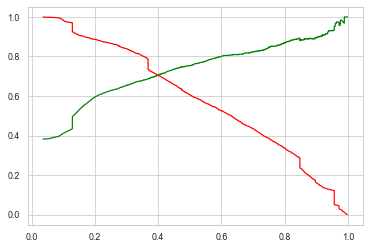

In [120]:
plt.plot(thresholds, p[:-1], 'g-')
plt.plot(thresholds, r[:-1], 'r-')
plt.show()

# Step 8. Predictions on the Test Set

In [121]:
X_test.head()

,TotalVisits,Total Time Spent on Website,API,Lead Add Form,Organic Search,Converted to Lead,Page Visited on Website,SMS Sent,Human Resource Management,Marketing Management,Operations Management
6906,4.0,1530,0,0,0,0,0,1,1,0,0
1873,2.0,186,0,0,0,0,0,1,0,0,0
771,7.0,49,1,0,0,0,0,0,0,0,0
4495,4.0,144,0,0,0,0,0,0,0,0,0
9061,2.0,1788,0,0,0,0,0,0,0,0,0


In [122]:
X_test = X_test[col]
X_test.head()

,Total Time Spent on Website,API,Lead Add Form,Converted to Lead,Page Visited on Website,SMS Sent,Marketing Management,Operations Management
6906,1530,0,0,0,0,1,0,0
1873,186,0,0,0,0,1,0,0
771,49,1,0,0,0,0,0,0
4495,144,0,0,0,0,0,0,0
9061,1788,0,0,0,0,0,0,0


In [123]:
# 1. Instantiate a StandardScaler Object
scaler = StandardScaler()

# 2. Create a list of numeric variables
numeric_data = ['Total Time Spent on Website']
X_test[numeric_data].head()

,Total Time Spent on Website
6906,1530
1873,186
771,49
4495,144
9061,1788


In [124]:
# 3. Fit and Transform the data
X_test[numeric_data] = scaler.fit_transform(X_test[numeric_data])
X_test.head()

,Total Time Spent on Website,API,Lead Add Form,Converted to Lead,Page Visited on Website,SMS Sent,Marketing Management,Operations Management
6906,1.891958,0,0,0,0,1,0,0
1873,-0.542475,0,0,0,0,1,0,0
771,-0.790628,1,0,0,0,0,0,0
4495,-0.618551,0,0,0,0,0,0,0
9061,2.359282,0,0,0,0,0,0,0


In [125]:
X_test_sm = sm.add_constant(X_test)

### Making predictions on the test set

In [126]:
y_test_pred = res.predict(X_test_sm)

In [127]:
y_test_pred[:10]

6906    0.863671
1873    0.345854
771     0.139863
4495    0.110218
9061    0.720967
4929    0.342408
2308    0.157075
1034    0.095949
9033    0.093516
7008    0.918531
dtype: float64

In [128]:
# Convert y_test_pred to a dataframe
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
6906,0.863671
1873,0.345854
771,0.139863
4495,0.110218
9061,0.720967


In [129]:
# Convert y_test to a dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,Converted
6906,1
1873,0
771,0
4495,0
9061,1


In [130]:
# Put CustId to index
y_test_df['StudentID'] = y_test_df.index

In [131]:
# Remove index for both dataframes to append them side-by-side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [132]:
# Append y_test_df to y_pred_1
y_pred_final = pd.concat((y_test_df, y_pred_1), axis=1)

In [133]:
y_pred_final.head()

,Converted,StudentID,0
0,1,6906,0.863671
1,0,1873,0.345854
2,0,771,0.139863
3,0,4495,0.110218
4,1,9061,0.720967


In [134]:
# Rename the column
y_pred_final = y_pred_final.rename(columns = {'Converted': 'HotLead', 0: 'HotLead_Prob'})

In [135]:
y_pred_final.head()

,HotLead,StudentID,HotLead_Prob
0,1,6906,0.863671
1,0,1873,0.345854
2,0,771,0.139863
3,0,4495,0.110218
4,1,9061,0.720967


In [136]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['StudentID', 'HotLead', 'HotLead_Prob'], axis = 1)

In [137]:
y_pred_final.head()

,StudentID,HotLead,HotLead_Prob
0,6906,1,0.863671
1,1873,0,0.345854
2,771,0,0.139863
3,4495,0,0.110218
4,9061,1,0.720967


In [138]:
y_pred_final['final_predicted'] = y_pred_final.HotLead_Prob.map(lambda x: 1 if x > 0.35 else 0)
y_pred_final.head()

,StudentID,HotLead,HotLead_Prob,final_predicted
0,6906,1,0.863671,1
1,1873,0,0.345854,0
2,771,0,0.139863,0
3,4495,0,0.110218,0
4,9061,1,0.720967,1


In [139]:
# Let's check out the overall accuracy
print('Accuracy : %0.2f'%(metrics.accuracy_score(y_pred_final.HotLead, y_pred_final.final_predicted)))

Accuracy : 0.78


In [140]:
# Confusion Matrix
confusion_test = metrics.confusion_matrix(y_pred_final.HotLead, y_pred_final.final_predicted)
confusion_test

array([[1260,  400],
       [ 209,  858]])

In [141]:
TP = confusion_test[1,1]
FP = confusion_test[0,1]
TN = confusion_test[0,0]
FN = confusion_test[1,0]

In [142]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8041237113402062

In [143]:
# Let us calculate specificity
TN / float(TN+FP)

0.7590361445783133

In [144]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.24096385542168675


In [145]:
# positive predictive value 
print (TP / float(TP+FP))

0.6820349761526232


In [146]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8577263444520081


## **Precision and Recall**
### ***Precision***
 
#### TP/(TP+FP)

### ***Recall***
#### TP/(FN+TP)


In [147]:
print('Precision = %0.2f'%(confusion_test[1,1]/(confusion_test[0,1]+confusion_test[1,1])))

Precision = 0.68


In [148]:
print('Recall = %0.2f'%(confusion_test[1,1]/(confusion_test[1,0]+confusion_test[1,1])))

Recall = 0.80


# Conclusion

On applying Logistic Regression on the problem at hand, we drill down the required parameters that effect the probability of Hot Leads conversion to the following list. 

|   Variables                    |   Coefficient  |
|--------------------------------|----------------|
|   const                        |   -1.4575      |
|   Total Time Spent on Website  |   1.0201       |
|   API                          |   0.4476       |
|   Lead Add Form                |   4.0795       |
|   Converted to Lead            |   -1.0033      |
|   Page Visited on Website      |   -0.362       |
|   SMS Sent                     |   1.3736       |
|   Marketing Management         |   0.4415       |
|   Operations Management        |   0.4317       |


Here we can see that if the lead has a higher total time spent on the website, lead originated from the API or lead add form, last activity is SMS sent, and Specialization is marketing management or operations management, it has a very higher chance of a conversion. 
And, if the lead’s last activity is converted to lead or page visited on the website, and have a lower total time spent on the website, it has a very lower chance of a conversion.

## Accuracy, Sensitivity and Specificity

Accuracy determines the overall predicted accuracy of the model. Our model above is **~78%** accurate.

Sensitivity measures the proportion of actual positives that are correctly identified. This gives us the required figure of how many leads are actually converted if we predict X leads. So our model has a sensitivity value of **~80%**.

Specificity measures the proportion of negatives which are correctly identified. The model has a specificity of **~76%**.